# FNO to reconstruct temperature field with material field

To simplify problem, only use 1 mask

In [2]:
# load packages

import torch
import matplotlib.pyplot as plt

import sys
import wandb
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from pathlib import Path

device = 'cpu'

In [4]:
# pack custom heat conduction dataset (k and u)

import numpy as np
from typing import Union, List
from torch.utils.data import DataLoader
from neuralop.data.datasets.tensor_dataset import TensorDataset
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer
from neuralop.data.transforms.data_processors import DefaultDataProcessor
from einops import rearrange

class HeatData:
    def __init__(self,
                 root_dir: Union[Path, str],
                 n_train: int=950,
                 n_tests: List[int]=[50,50],
                 batch_size: int=16,
                 test_batch_sizes: List[int]=[16,16],
                 train_resolution: int=32,
                 test_resolutions: int=[32,64],
                 encode_input: bool=True,
                 encode_output: bool=True,
                 encoding="channel-wise",
                 channel_dim=1):
        
        if isinstance(root_dir, str):
            root_dir = Path(root_dir)
            
        self.root_dir = root_dir
        
        self.batch_size = batch_size
        self.test_resolutions = test_resolutions
        self.test_batch_sizes = test_batch_sizes

        
        ### load npy data
        x_data_res32 = np.load(root_dir / f'k_n1000_res32.npy')
        y_data_res32 = np.load(root_dir / f'u_n1000_res32.npy')
        x_data_res64 = np.load(root_dir / f'k_n50_res64.npy')
        y_data_res64 = np.load(root_dir / f'u_n50_res64.npy')
        
        ### pack train data
        x_data_res32 = rearrange(x_data_res32, 'n x y -> n 1 x y')  # add channel dimension
        y_data_res32 = rearrange(y_data_res32, 'n x y -> n 1 x y')  # add channel dimension
        x_data_res32 = torch.from_numpy(x_data_res32).float()
        y_data_res32 = torch.from_numpy(y_data_res32).float()
        
        x_data_res64 = rearrange(x_data_res64, 'n x y -> n 1 x y')  # add channel dimension
        y_data_res64 = rearrange(y_data_res64, 'n x y -> n 1 x y')  # add channel dimension
        x_data_res64 = torch.from_numpy(x_data_res64).float()
        y_data_res64 = torch.from_numpy(y_data_res64).float()
        
        x_train = x_data_res32[:n_train]
        y_train = y_data_res32[:n_train]
        
        ### pack test data
        x_test_res32 = x_data_res32[n_train:n_train+n_tests[0]]
        y_test_res32 = y_data_res32[n_train:n_train+n_tests[0]]
        x_test_res64 = x_data_res64[:n_tests[1]]
        y_test_res64 = y_data_res64[:n_tests[1]]

        ### encode
        if encode_input:
            if encoding == "channel-wise":
                reduce_dims = list(range(x_train.ndim))
                # preserve mean for each channel
                reduce_dims.pop(channel_dim)
            elif encoding == "pixel-wise":
                reduce_dims = [0]

            input_encoder = UnitGaussianNormalizer(dim=reduce_dims)
            input_encoder.fit(x_train)
        else:
            input_encoder = None

        if encode_output:
            if encoding == "channel-wise":
                reduce_dims = list(range(y_train.ndim))
                # preserve mean for each channel
                reduce_dims.pop(channel_dim)
            elif encoding == "pixel-wise":
                reduce_dims = [0]

            output_encoder = UnitGaussianNormalizer(dim=reduce_dims)
            output_encoder.fit(y_train)
        else:
            output_encoder = None
            
        ### save train dataset
        self._train_db = TensorDataset(
            x_train,
            y_train,
        )
        
        ### create DataProcessor
        self._data_processor = DefaultDataProcessor(in_normalizer=input_encoder,
                                                   out_normalizer=output_encoder)
        
        ### save test datasets
        self._test_dbs = {}
        self._test_dbs[32] = TensorDataset(
            x_test_res32,
            y_test_res32,
        )
        self._test_dbs[64] = TensorDataset(
            x_test_res64,
            y_test_res64,
        )
        
        del x_data_res32, y_data_res32, x_data_res64, y_data_res64
    
    @property
    def data_processor(self):
        return self._data_processor
    
    @property
    def train_db(self):
        return self._train_db
    
    @property
    def test_dbs(self):
        return self._test_dbs
        

def load_heat_npy(
    root_dir: Union[Path, str],
    n_train: int,
    n_tests: List[int],
    batch_size: int,
    test_batch_sizes: List[int],
    train_resolution: int,
    test_resolutions: int=[16,32],
    encode_input: bool=False,
    encode_output: bool=True,
    encoding="channel-wise",
    channel_dim=1
):
    dataset = HeatData(
        root_dir=root_dir,
        n_train=n_train,
        n_tests=n_tests,
        batch_size=batch_size,
        test_batch_sizes=test_batch_sizes,
        train_resolution=train_resolution,
        test_resolutions=test_resolutions,
        encode_input=encode_input,
        encode_output=encode_output,
        encoding=encoding,
        channel_dim=channel_dim
    )
    
    # return dataloaders
    train_loader = DataLoader(
        dataset.train_db,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        persistent_workers=False,
    )
    
    test_loaders = {}
    for res, test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(
            dataset.test_dbs[res],
            batch_size=test_bsize,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            persistent_workers=False,
        )

    return train_loader, test_loaders, dataset.data_processor

# -----------------------------------------------------------------------------
# load data
data_dir = Path("../data/heat/")

train_loader, test_loaders, data_processor = load_heat_npy(
    root_dir=data_dir,
    n_train=950,
    n_tests=[50, 50],
    batch_size=16,
    test_batch_sizes=[16, 16],
    train_resolution=32,
    test_resolutions=[32, 64],
    encode_input=True,
    encode_output=True,
    encoding="channel-wise",
    channel_dim=1
)
data_processor = data_processor.to(device)

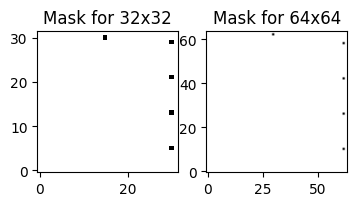

In [5]:
# mask for 32
pos32 = np.array([
    (30, 15),
    (5, 30),  (13, 30),
    (21, 30), (29, 30),
])

pos64 = np.array([
    (62, 30),
    (10, 62), (26, 62),
    (42, 62), (58, 62),
])

# positions for mask 32
mask32 = np.zeros((1, 32, 32))
for pos in pos32:
    mask32[0, pos[0], pos[1]] = 1
    
# positions for mask 64
mask64 = np.zeros((1, 64, 64))
for pos in pos64:
    mask64[0, pos[0], pos[1]] = 1

# plot masks
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(mask32[0], cmap='gray_r', origin='lower')
plt.title('Mask for 32x32')
plt.subplot(1, 2, 2)
plt.imshow(mask64[0], cmap='gray_r', origin='lower')
plt.title('Mask for 64x64')
plt.show()

mask32 = torch.tensor(mask32, device=device)
mask64 = torch.tensor(mask64, device=device)

In [6]:
# generate sparse dataset with original dataset
from torch.utils.data import DataLoader

# modify x to y*mask for train dataset
mod_train_data = []
for batch in train_loader.dataset:
    x = batch['x'].to(device).float()
    y = batch['y'].to(device).float()
    x_mod_first = (y * mask32).float()
    x_mod = torch.cat([x_mod_first, x], dim=0)  # concatenate original x to x_mod
    mod_train_data.append({'x': x_mod, 'y': y})

mod_train_loader = DataLoader(mod_train_data, batch_size=16, shuffle=True)

# modify x to y*mask for test dataset
mod_test_loaders = {}
for (res, test_loader), mask in zip(test_loaders.items(), [mask32, mask64]):
    mod_test_data = []
    for batch in test_loader.dataset:
        x = batch['x'].to(device).float()
        y = batch['y'].to(device).float()
        x_mod_first = (y * mask).float()
        x_mod = torch.cat([x_mod_first, x], dim=0)  # concatenate original x to x_mod
        mod_test_data.append({'x': x_mod, 'y': y})

    mod_test_loaders[res] = DataLoader(mod_test_data,
                                       batch_size=test_loader.batch_size,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True)


x.shape: torch.Size([2, 32, 32])
y.shape: torch.Size([1, 32, 32])


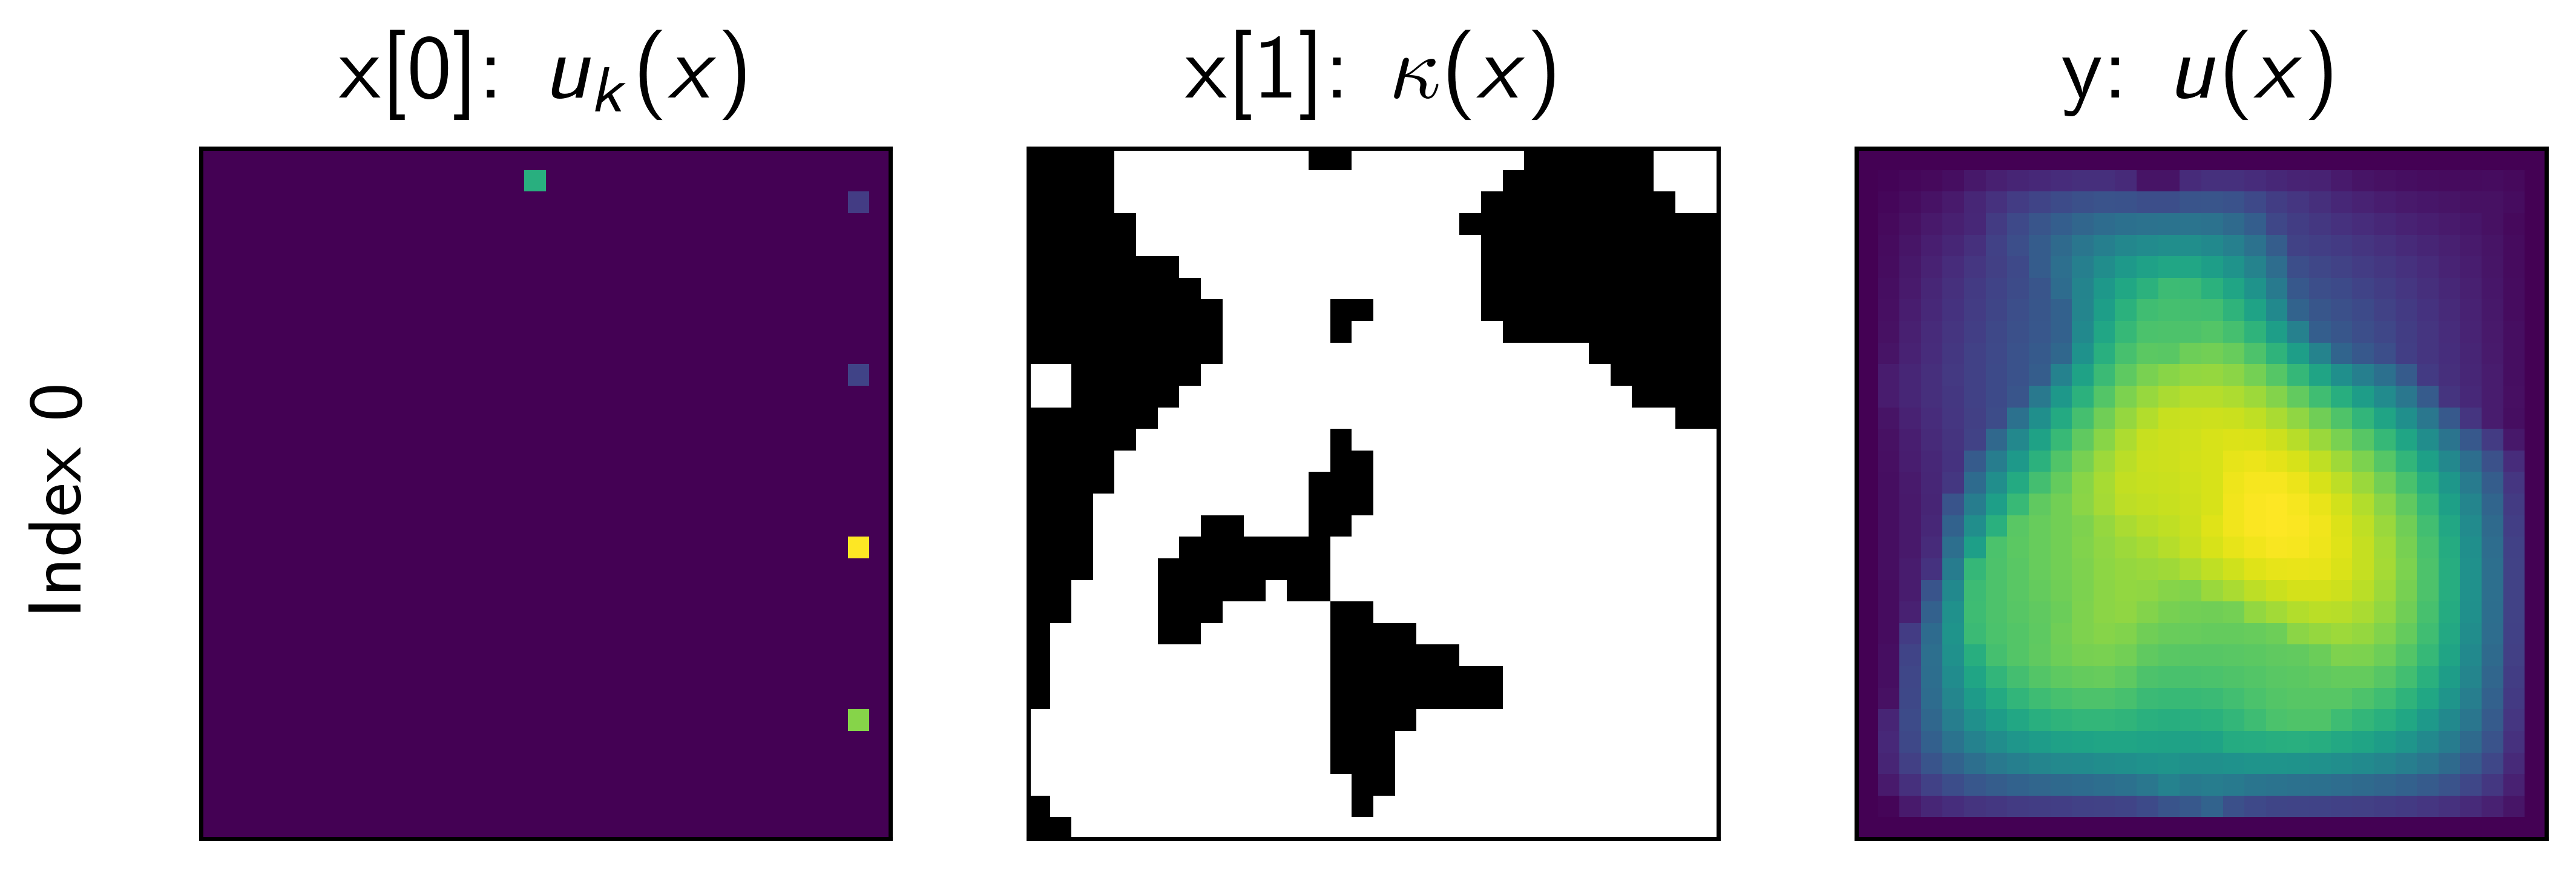

In [25]:
import cm_vis
plt.style.use("sans")
# check data
index = 0
# data = mod_train_loader.dataset[index]
data = mod_test_loaders[32].dataset[index]
x = data['x']
y = data['y']
print(f'x.shape: {x.shape}') # binary value (0 or 1), x grid, y grid
print(f'y.shape: {y.shape}') # solution value, x grid, y grid

# plot input x and input y
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 3, 1)
ax.annotate(f"Index {index}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
ax.imshow(x[0], origin='lower')
ax.set_title('x[0]: $u_k(x)$')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(x[1], origin='lower', cmap='gray_r')
ax.set_title('x[1]: $\kappa(x)$')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(y.squeeze(), origin='lower')
ax.set_title('y: $u(x)$')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [26]:
# model setup
model = FNO(n_modes=(16, 16),
             in_channels=2,
             out_channels=1,
             hidden_channels=64,
             n_layers=4,
             positional_embedding="grid",
             projection_channel_ratio=2)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 4769601 parameters.


In [27]:
epochs=20
learning_rate=1e-3
scheduler_step=10
scheduler_gamma=0.5

# training setup
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate, # learning rate
    weight_decay=1e-4
)

# use StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step, gamma=scheduler_gamma
)

# losses setup
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss # use H1 loss
eval_losses = {'h1': h1loss, 'l2':l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()



### MODEL ###
 FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([64, 64, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
          (1): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(4, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(1

In [28]:
# %%capture out
trainer = Trainer(
    model=model,
    n_epochs=epochs,
    data_processor=data_processor,
    device=device,
    mixed_precision=False,
    eval_interval=1,
    log_output=False,
    use_distributed=False,
    verbose=True,
    wandb_log = False
)

# train
trainer.train(
    train_loader=mod_train_loader,
    test_loaders=mod_test_loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,
    save_every=1,
    save_dir="./ckpt/fno_with_k/"
)

Training on 950 samples
Testing on [50, 50] samples         on resolutions [32, 64].
Raw outputs of shape torch.Size([16, 1, 32, 32])
[0] time=10.32, avg_loss=0.6482, train_err=10.2633
Eval: 32_h1=0.3746, 32_l2=0.2828, 64_h1=0.4253, 64_l2=0.1736
[Rank 0]: saved training state to ./ckpt/fno_with_k/
[1] time=9.92, avg_loss=0.2889, train_err=4.5741
Eval: 32_h1=0.2637, 32_l2=0.1551, 64_h1=0.3554, 64_l2=0.0957
[Rank 0]: saved training state to ./ckpt/fno_with_k/
[2] time=9.94, avg_loss=0.2255, train_err=3.5708
Eval: 32_h1=0.2064, 32_l2=0.1096, 64_h1=0.3186, 64_l2=0.1103
[Rank 0]: saved training state to ./ckpt/fno_with_k/
[3] time=9.97, avg_loss=0.1928, train_err=3.0531
Eval: 32_h1=0.2007, 32_l2=0.1217, 64_h1=0.3206, 64_l2=0.1609
[Rank 0]: saved training state to ./ckpt/fno_with_k/
[4] time=10.05, avg_loss=0.1718, train_err=2.7197
Eval: 32_h1=0.1801, 32_l2=0.1114, 64_h1=0.3056, 64_l2=0.1501
[Rank 0]: saved training state to ./ckpt/fno_with_k/
[5] time=10.02, avg_loss=0.1520, train_err=2.406

{'train_err': 1.212762110431989,
 'avg_loss': 0.07659550171149404,
 'avg_lasso_loss': None,
 'epoch_train_time': 10.242157899999938,
 '32_h1': tensor(0.1020),
 '32_l2': tensor(0.0593),
 '64_h1': tensor(0.2666),
 '64_l2': tensor(0.1451)}

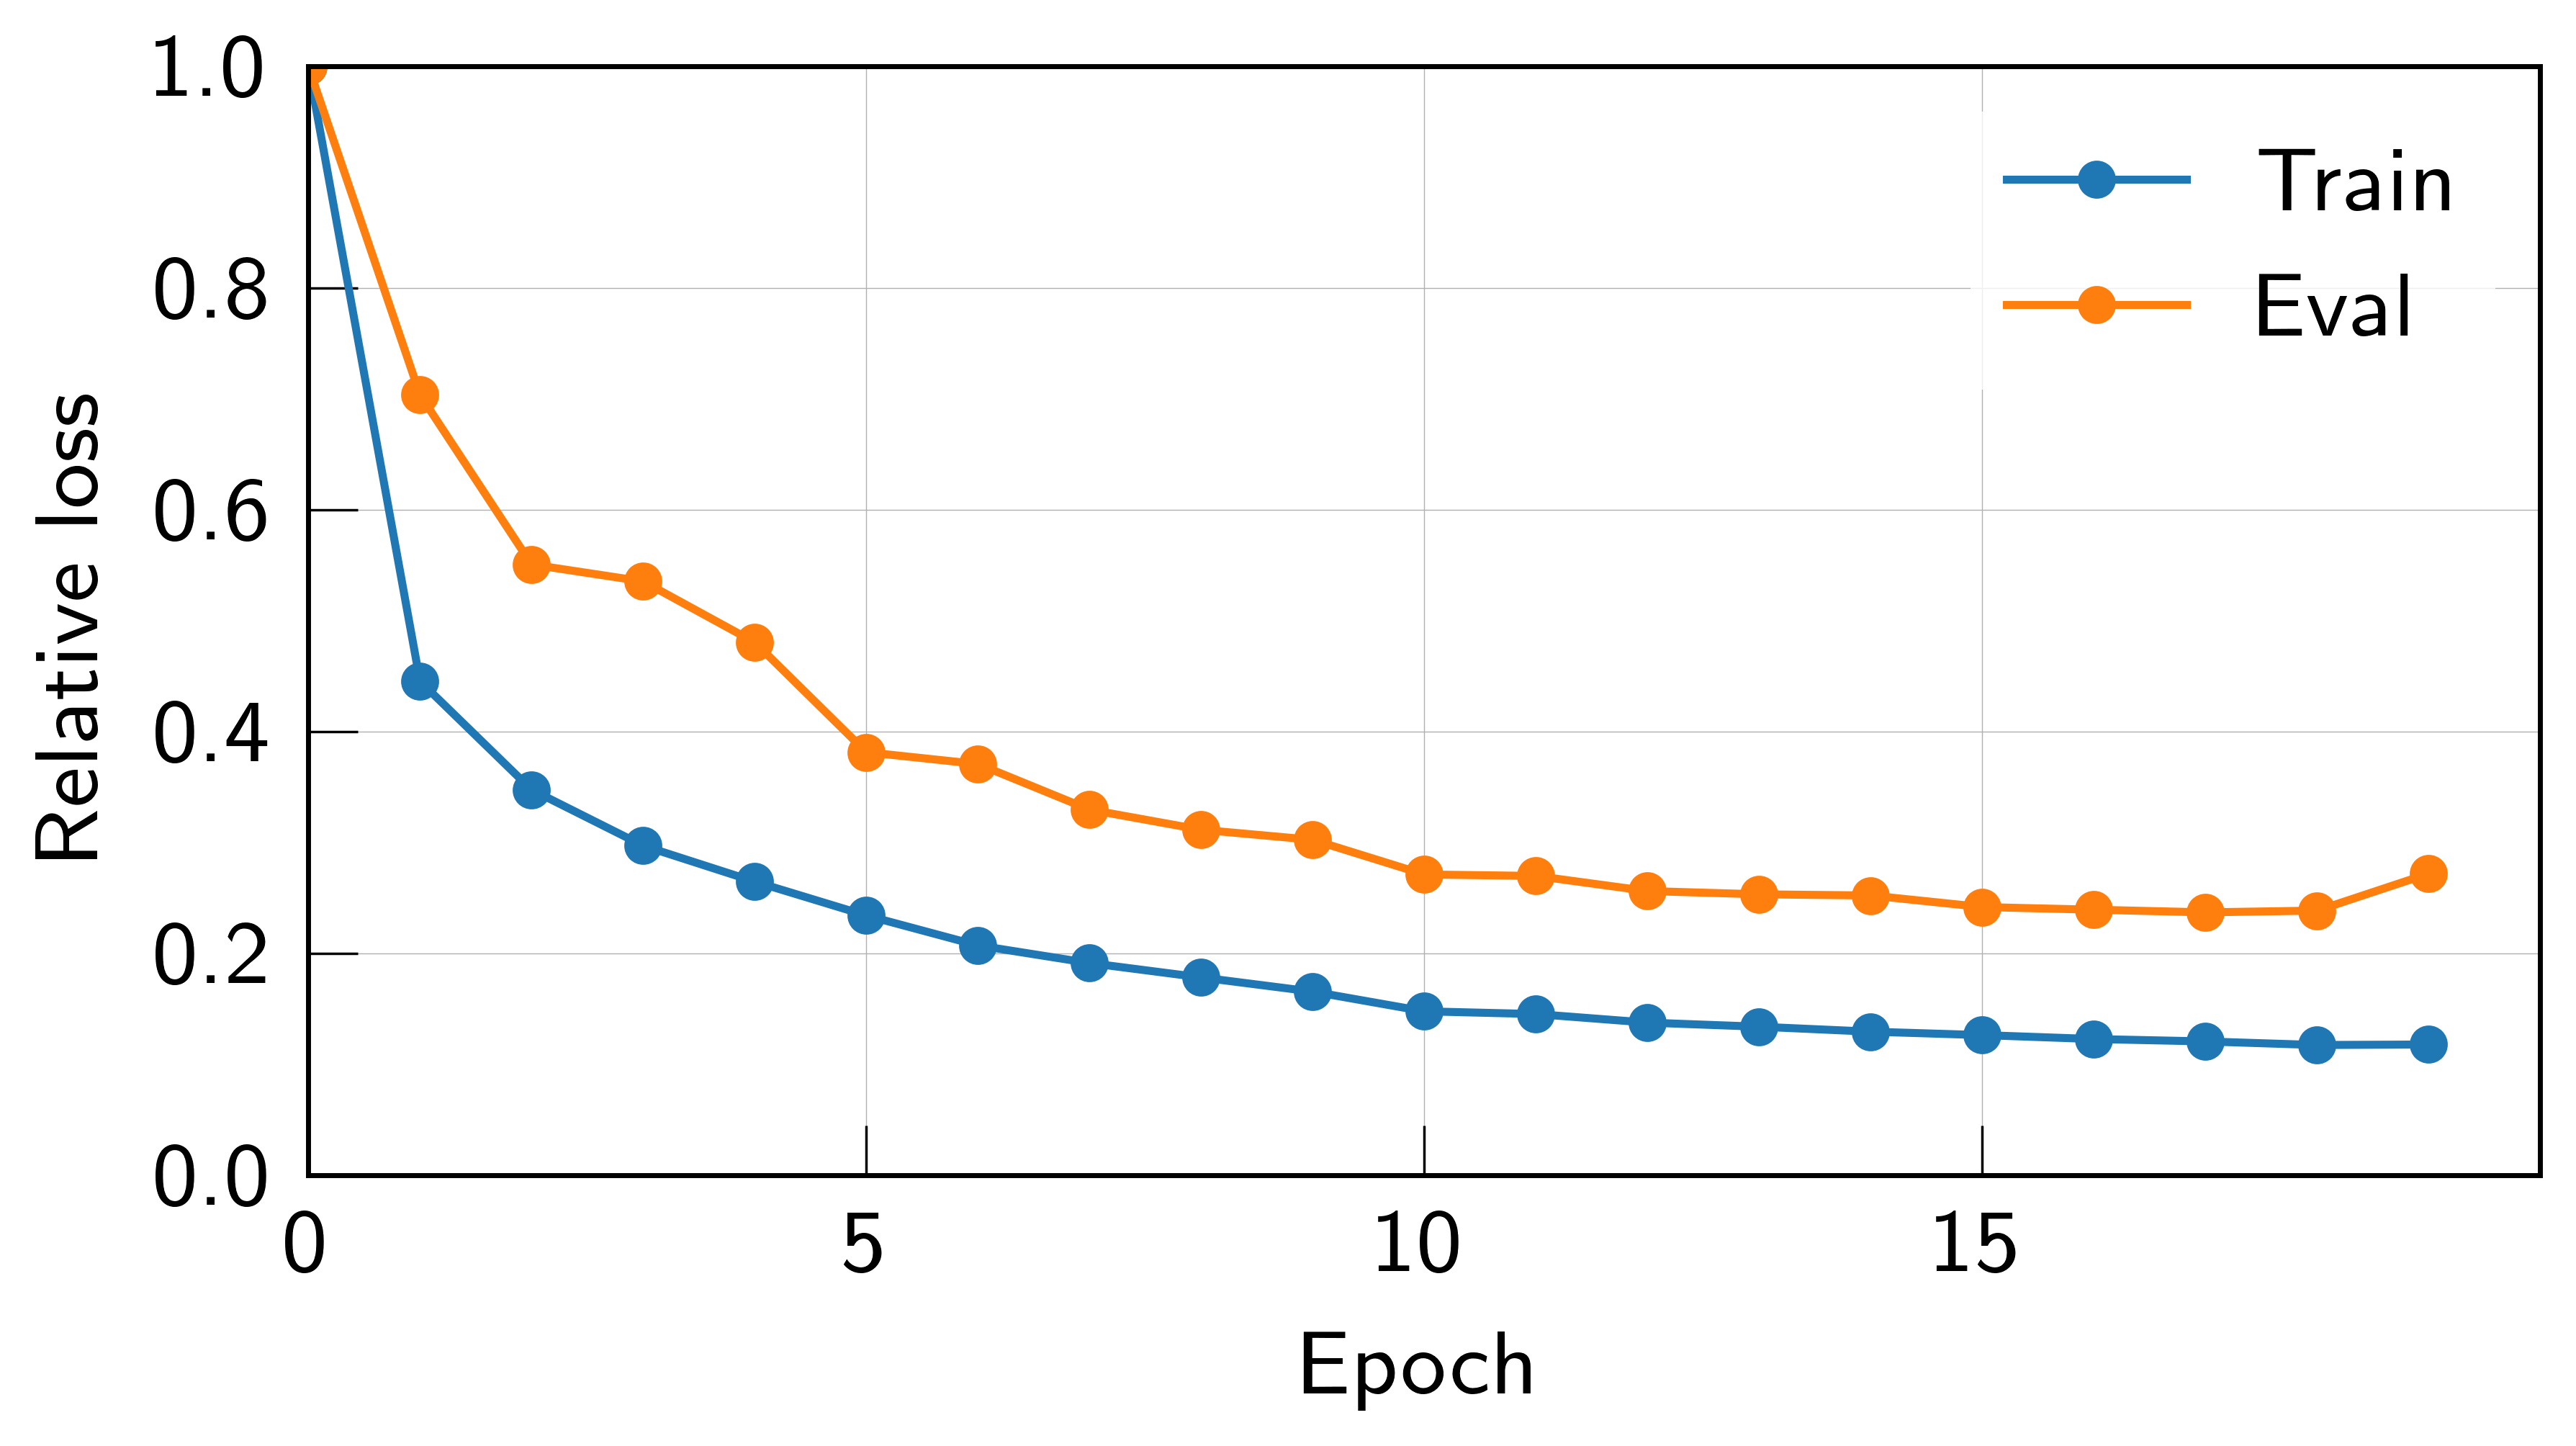

In [29]:
# plot train and eval loss
import re
import matplotlib.pyplot as plt

with open("./log/log_with_k.txt", 'r') as f:
    log = f.read()

train_loss = [float(x) for x in re.findall(r"avg_loss=([0-9.]+)", log)]
eval_loss = [float(x) for x in re.findall(r"32_h1=([0-9.]+)", log)]

train_loss_rel = [x / train_loss[0] for x in train_loss]
eval_loss_rel = [x / eval_loss[0] for x in eval_loss]

# plot
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(train_loss_rel, '-o', label='Train')
ax.plot(eval_loss_rel, '-o', label='Eval')
ax.set_xlabel('Epoch')
ax.set_ylabel('Relative loss')
ax.set(xlim=[0, len(train_loss)], 
       ylim=[0, 1]
       )
ax.set_xticks(range(0, len(train_loss), 5))
ax.legend()
plt.show()

In [35]:
# save model
model.save_checkpoint(save_folder='./model', save_name='fno_with_k')

In [7]:
# reload model
model_reload = FNO.from_checkpoint('./model', save_name='fno_with_k')

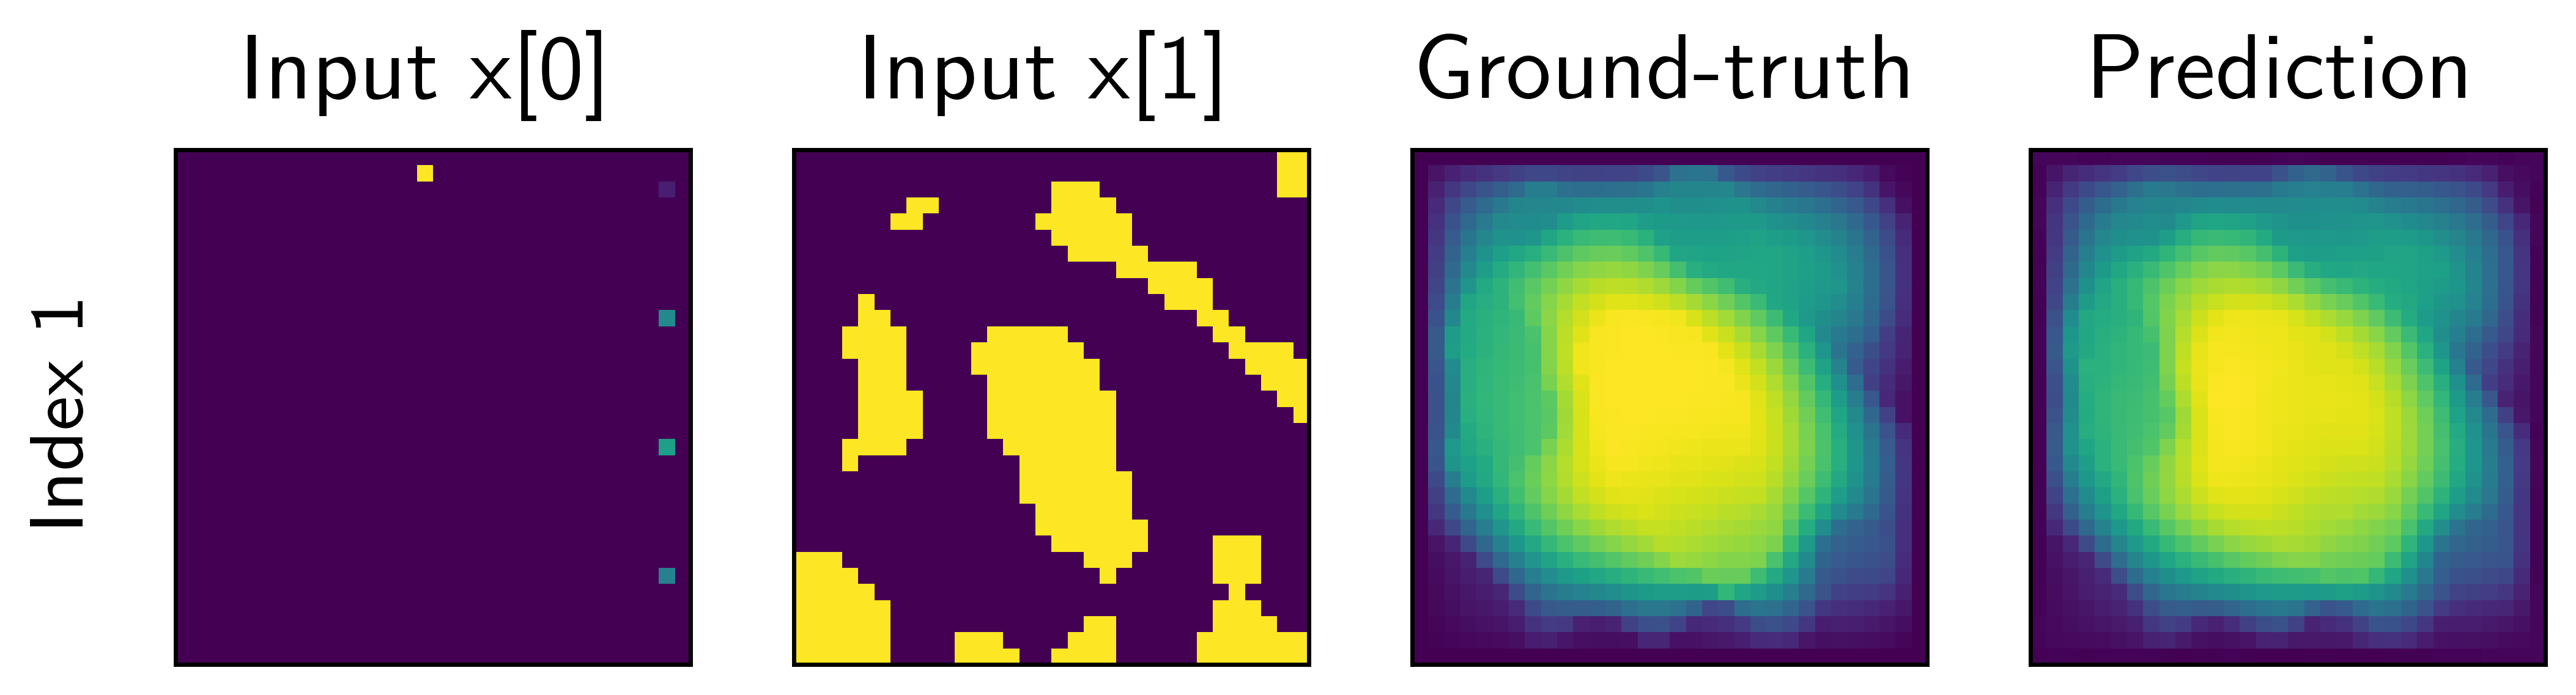

In [11]:
# plot prediction
# model_use = model.to(device)
model_use = model_reload.to(device)

test_samples = mod_test_loaders[32].dataset
idx = 1

data = test_samples[idx]

data_processor.to(device)
data_processor.eval()
data = data_processor.preprocess(data, batched=False)


x = data['x']
y = data['y']
out = model_use(x)

# postprocess data
# out, _ = data_processor.postprocess(out, data)

# plot input x and input y
import cm_vis 
plt.style.use("sans")

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 4, 1)
ax.annotate(f"Index {idx}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
ax.imshow(x[0,0,:,:], origin='lower')
ax.set_title('Input x[0]')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 4, 2)
ax.imshow(x[0,1,:,:], origin='lower')
ax.set_title('Input x[1]')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 4, 3)
ax.imshow(y.squeeze(), origin='lower')
ax.set_title('Ground-truth')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 4, 4)
ax.imshow(out.squeeze().detach().numpy(), origin='lower')
ax.set_title('Prediction')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

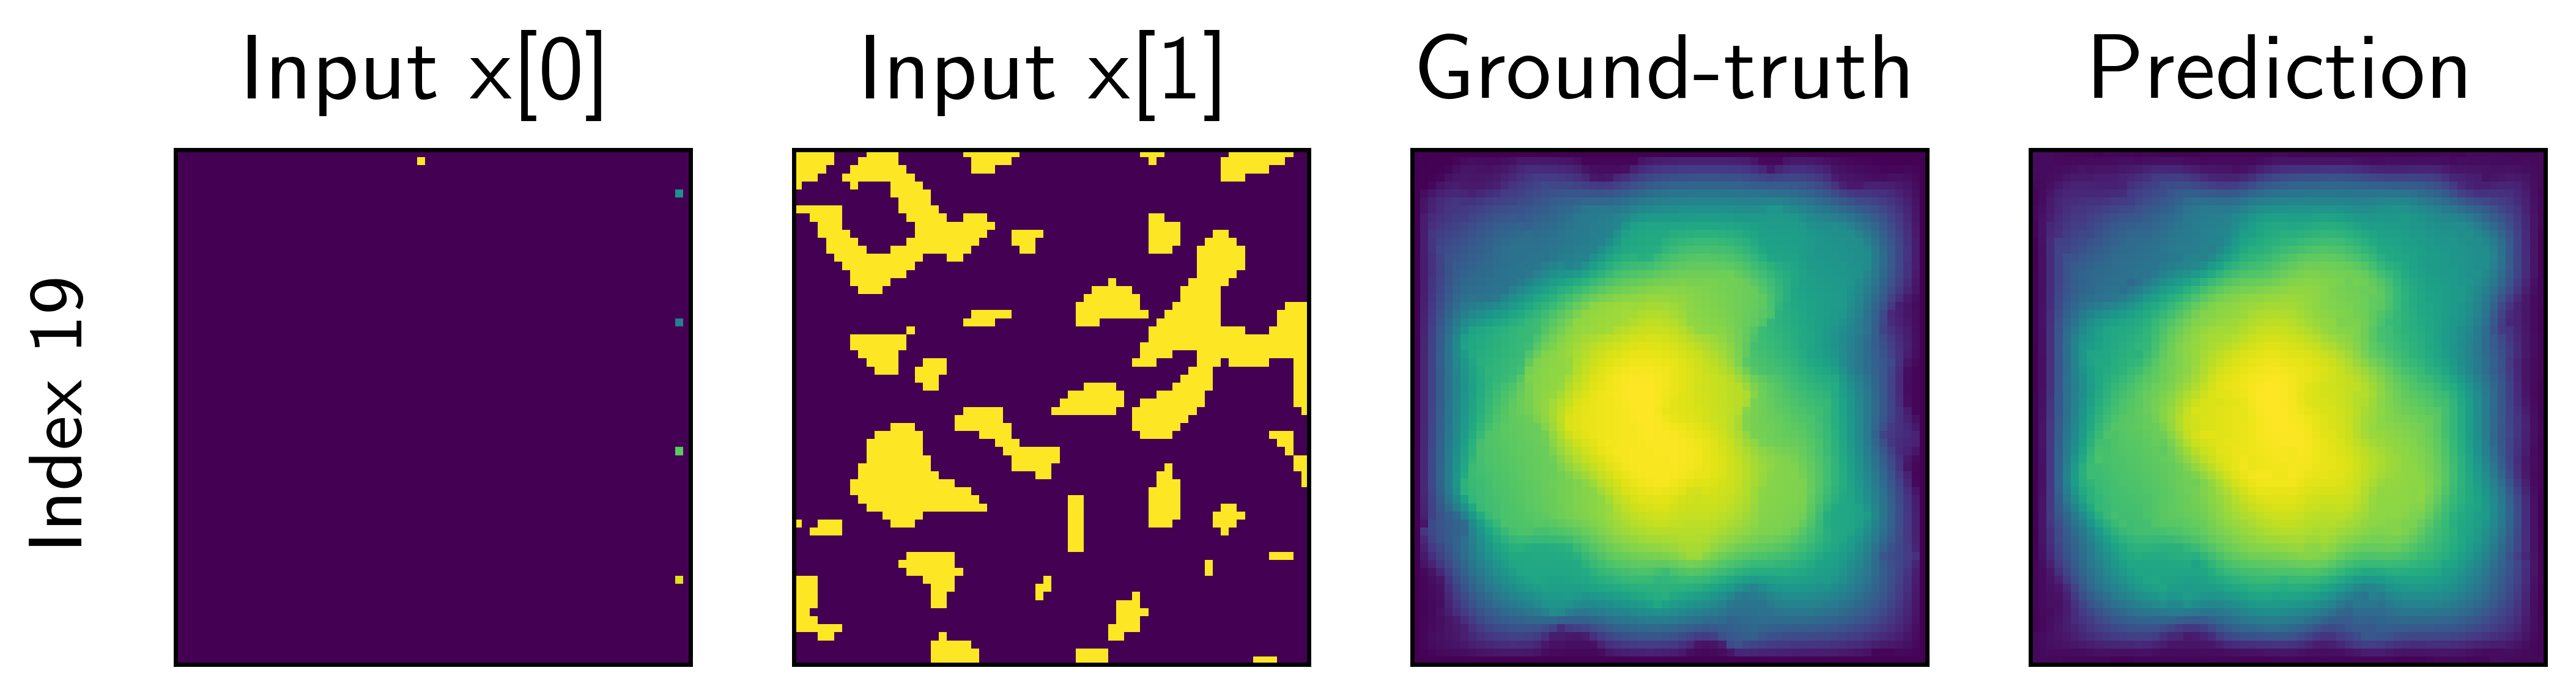

In [12]:
# plot prediction
# model_use = model.to(device)
model_use = model_reload.to(device)

test_samples = mod_test_loaders[64].dataset
idx = 19

data = test_samples[idx]

data_processor.to(device)
data_processor.eval()
data = data_processor.preprocess(data, batched=False)


x = data['x']
y = data['y']
out = model_use(x)

# postprocess data
# out, _ = data_processor.postprocess(out, data)

# plot input x and input y
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 4, 1)
ax.annotate(f"Index {idx}", xy=(-0.15, 0.5), 
             xycoords="axes fraction",
             ha="right", va="center", rotation=90)
ax.imshow(x[0,0,:,:], origin='lower')
ax.set_title('Input x[0]')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 4, 2)
ax.imshow(x[0,1,:,:], origin='lower')
ax.set_title('Input x[1]')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 4, 3)
ax.imshow(y.squeeze(), origin='lower')
ax.set_title('Ground-truth')
ax.set_xticks([])
ax.set_yticks([])

ax = fig.add_subplot(1, 4, 4)
ax.imshow(out.squeeze().detach().numpy(), origin='lower')
ax.set_title('Prediction')
ax.set_xticks([])
ax.set_yticks([])

plt.show()